In [8]:
#2023년 기준 colab 기본 tensorflow 버전이 2.x로 올라가서 다운그레이드 하기 위함
!pip uninstall tensorflow -y
#그러나 tensorflow 1 설치 자체를 막아놔서 현재 코드 실행 불가능...

In [11]:
#@markdown #Install and import the required components

%%time
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/stylegan

%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14
import os
import math
import pickle
import imageio
import PIL.Image
import numpy as np
from PIL import Image
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

path = '/content/gdrive/MyDrive/stylegan/networks/other'
os.makedirs(path, exist_ok=True)

!pip install https://github.com/podgorskiy/dnnlib/releases/download/0.0.1/dnnlib-0.0.1-py3-none-any.whl

import dnnlib
import pretrained_networks
import dnnlib.tflib as tflib

clear_output()
print(tf.__version__)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/stylegan


ValueError: ignored

In [3]:
#@markdown #Declare the necessary functions

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
def move_latent_and_save(latent_vector, direction_file, coeffs, Gs_network, Gs_syn_kwargs):
    direction = np.load('/content/gdrive/MyDrive/stylegan/latent_directions/' + direction_file)
    os.makedirs('/content/gdrive/MyDrive/stylegan/results/'+direction_file.split('.')[0], exist_ok=True)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[0][:8] = (latent_vector[0] + coeff*direction)[:8]
        images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
        result = PIL.Image.fromarray(images[0], 'RGB')
        result.thumbnail(size, PIL.Image.ANTIALIAS)
        result.save('/content/gdrive/MyDrive/stylegan/results/'+direction_file.split('.')[0]+'/'+str(i).zfill(3)+'.png')
        if len(coeffs)==1:
          return result

In [4]:
#@markdown #Upload a face image

from google.colab import files

path = '/content/gdrive/My Drive/stylegan/raw_images'
os.makedirs(path, exist_ok=True)

'''
uploaded = files.upload()
for fp in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fp, length=len(uploaded[fp])))
'''

fp='/content/gdrive/MyDrive/stylegan/raw_images/photo.png'
os.rename(fp, fp.replace(" ", ""))
fp = fp.replace(" ", "")
fn = 'photo.'+ fp.split('.')[-1]
!mv $fp /content/gdrive/MyDrive/stylegan/raw_images/$fn
clear_output()
print("Photo uploaded:\n")

img1 = PIL.Image.open('/content/gdrive/My Drive/stylegan/raw_images/'+fn)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), PIL.Image.LANCZOS)
display(img1)

NameError: ignored

In [5]:
#@markdown #Crop image: the facial part of the uploaded image

os.makedirs('/content/gdrive/MyDrive/stylegan/aligned_images', exist_ok=True)

os.makedirs('/content/gdrive/MyDrive/stylegan/generated_images', exist_ok=True)

!python align_images.py /content/gdrive/MyDrive/stylegan/raw_images/ /content/gdrive/MyDrive/stylegan/aligned_images/
align = !ls /content/gdrive/MyDrive/stylegan/aligned_images
clear_output()

for i in align:
  display(PIL.Image.open('/content/gdrive/MyDrive/stylegan/aligned_images/'+i).resize((256,256)))

NameError: ignored

In [6]:
#@markdown #Train a neural network
#@markdown ##Display the aligned image for modifying

#encode_image.py
import os
import argparse
import pickle
from tqdm import tqdm
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks
from encoder.generator_model import Generator
from encoder.perceptual_model import PerceptualModel


def split_to_batches(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def main():
    parser = argparse.ArgumentParser(description='Find latent representation of reference images using perceptual loss')
    parser.add_argument('--src_dir', default='/content/gdrive/MyDrive/stylegan/aligned_images/')
    parser.add_argument('--generated_images_dir', default='/content/gdrive/MyDrive/stylegan/generated_images/')
    parser.add_argument('--dlatent_dir', default='/content/gdrive/MyDrive/stylegan/latent_representations/')

    parser.add_argument('--network_pkl', default='/content/gdrive/MyDrive/stylegan/networks/other/generator_model-stylegan2-config-f.pkl')

    # for now it's unclear if larger batch leads to better performance/quality
    parser.add_argument('--batch_size', default=1, type=int)

    # Perceptual model params
    parser.add_argument('--image_size', default=256, type=int)
    parser.add_argument('--lr', default=1., type=float)
    parser.add_argument('--iterations', default=700, type=int)

    # Generator params
    parser.add_argument('--randomize_noise', default=False, type=bool)
    args, other_args = parser.parse_known_args()

    ref_images = [os.path.join(args.src_dir, x) for x in os.listdir(args.src_dir)]
    ref_images = list(filter(os.path.isfile, ref_images))

    if len(ref_images) == 0:
        raise Exception('%s is empty' % args.src_dir)

    os.makedirs(args.generated_images_dir, exist_ok=True)
    os.makedirs(args.dlatent_dir, exist_ok=True)

    # Initialize generator and perceptual model
    tflib.init_tf()
    generator_network, discriminator_network, Gs_network = pretrained_networks.load_networks(args.network_pkl)

    generator = Generator(Gs_network, args.batch_size, randomize_noise=args.randomize_noise)
    perceptual_model = PerceptualModel(args.image_size, layer=9, batch_size=args.batch_size)
    perceptual_model.build_perceptual_model(generator.generated_image)

    # Optimize (only) dlatents by minimizing perceptual loss between reference and generated images in feature space
    for images_batch in tqdm(split_to_batches(ref_images, args.batch_size), total=len(ref_images)//args.batch_size):
        names = [os.path.splitext(os.path.basename(x))[0] for x in images_batch]

        perceptual_model.set_reference_images(images_batch)
        op = perceptual_model.optimize(generator.dlatent_variable, iterations=args.iterations, learning_rate=args.lr)
        pbar = tqdm(op, leave=False, total=args.iterations)
        for loss in pbar:
            pbar.set_description(' '.join(names)+' Loss: %.2f' % loss)
        print(' '.join(names), ' loss:', loss)

        # Generate images from found dlatents and save them
        generated_images = generator.generate_images()
        generated_dlatents = generator.get_dlatents()
        for img_array, dlatent, img_name in zip(generated_images, generated_dlatents, names):
            img = PIL.Image.fromarray(img_array, 'RGB')
            img.save(os.path.join(args.generated_images_dir, f'{img_name}.png'), 'PNG')
            np.save(os.path.join(args.dlatent_dir, f'{img_name}.npy'), dlatent)

        generator.reset_dlatents()

if __name__ == "__main__":
  main()

fn = !ls latent_representations
pass

display_sbs('/content/gdrive/MyDrive/stylegan/generated_images/', '/content/gdrive/MyDrive/stylegan/aligned_images/', res = 512)

ModuleNotFoundError: ignored

In [ ]:
#@markdown #Use pretrained networks for accuracy and shorter training time (Optional)

network_pkl = '/content/gdrive/MyDrive/stylegan/networks/other/generator_model-stylegan2-config-f.pkl'

tflib.init_tf()
with open(network_pkl, "rb") as f:
  generator_network, discriminator_network, Gs_network = pickle.load(f)

w_avg = Gs_network.get_var('dlatent_avg')
noise_vars = [var for name, var in Gs_network.components.synthesis.vars.items() if name.startswith('noise')]
Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = 1
truncation_psi = 0.5
clear_output()

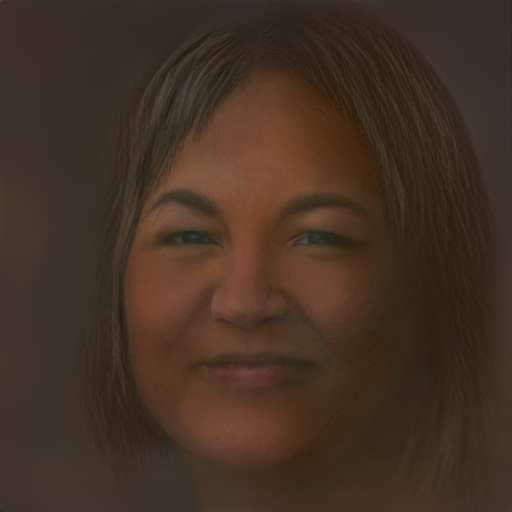

In [ ]:
#@title #Modify the face according to 3 parameters {run:"auto", display-mode: "form" }
from google.colab import files

v = np.load('/content/gdrive/MyDrive/stylegan/latent_representations/'+fn[0])
v = np.array([v])
!rm -rf results/3param

#@markdown Choose the first option
parameter1 = 'width' #@param ["age", "angle_horizontal", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eyes_open", "face_shape", "gender", "glasses", "height", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file1 = np.load('latent_directions/' + parameter1 + '.npy')
intensity1 = -2.5 #@param {type:"slider", min:-5, max:5, step:0.1}
boost_intensity1 = False #@param {type:"boolean"}
if boost_intensity1 == True:
  intensity1 *= 3

#@markdown Choose the second option
parameter2 = 'eyes_open' #@param ["age", "angle_horizontal", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eyes_open", "face_shape", "gender", "glasses", "height", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file2 = np.load('latent_directions/' + parameter2 + '.npy')
intensity2 = 2.5 #@param {type:"slider", min:-5, max:5, step:0.1}
boost_intensity2 = False #@param {type:"boolean"}
if boost_intensity2 == True:
  intensity2 *= 3

#@markdown Choose the third option
parameter3 = 'emotion_angry' #@param ["age", "angle_horizontal", "beauty", "emotion_angry", "emotion_disgust", "emotion_easy", "emotion_fear", "emotion_happy", "emotion_sad", "emotion_surprise", "eyes_open", "face_shape", "gender", "glasses", "height", "race_black", "race_white", "race_yellow", "smile", "width"]
direction_file3 = np.load('latent_directions/' + parameter3 + '.npy')
intensity3 = 2 #@param {type:"slider", min:-5, max:5, step:0.1}

#@markdown *Check for parameter intensifying (if needed)
boost_intensity3 = False #@param {type:"boolean"}
if boost_intensity3 == True:
  intensity3 *= 3

#@markdown Image resolution
resolution = "512" #@param [128, 256, 512, 1024]
size = int(resolution), int(resolution)

def move_latent_and_save_3_param(latent_vector, direction_intensity, Gs_network, Gs_syn_kwargs):
    os.makedirs('/content/gdrive/MyDrive/stylegan/results/3param', exist_ok=True)
    new_latent_vector = latent_vector.copy()
    new_latent_vector[0][:8] = (latent_vector[0] + direction_intensity)[:8]
    images = Gs_network.components.synthesis.run(new_latent_vector, **Gs_syn_kwargs)
    result = PIL.Image.fromarray(images[0], 'RGB')
    result.thumbnail(size, PIL.Image.ANTIALIAS)
    result.save('/content/gdrive/MyDrive/stylegan/results/3param/result_3param.png')
    return result

direction_intensity = (direction_file1*intensity1) + (direction_file2*intensity2) + (direction_file3*intensity3)
move_latent_and_save_3_param(v, direction_intensity, Gs_network, Gs_syn_kwargs)

In [ ]:
#@markdown #Survey

안녕하십니까? 저희는 <머신러닝을 이용한 몽타주 이미지 생성>에 대한 프로젝트를 진행중인 학생들입니다.

본 설문의 소요 시간은 약 3~5분입니다.

💥모든 과정에 걸쳐 응답자의 익명성은 철저히 보장됩니다💥

바쁘시겠지만, 설문에 참여해주시면 정말 많은 도움이 될 것 같습니다.

본 설문조사는 머신러닝을 이용한 이미지와 실제 우리가 찾고자하는 사람의 얼굴과 비교하여 얼마나 비슷한지 유사도를 설문하는 것을 목표로 조사를 실시했습니다. 각 항목별 유사도를 평가(5점 만점)해주시면 되겠습니다. 감사합니다.

In [ ]:
#@markdown Google form link: https://forms.gle/PvVB6YS9H28SbQ74A

In [ ]:
#@markdown Grade your similarity points for each parameters (0~5 Points)

Eyes = 4 #@param {type:"slider", min:0, max:5, step:0.1}

Hair Style = 1.3 #@param {type:"slider", min:0, max:5, step:0.1}

Hair Color = 1.1 #@param {type:"slider", min:0, max:5, step:0.1}

Mouth size & shape = 0.9 #@param {type:"slider", min:0, max:5, step:0.1}
